# Home Exercise 2 on Text Generation
Implement a sequence2sequence to summarize the text. 

Data: **CNN-DailyMail News Text Summarization** 

**Note: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, model training and model evaluation. (Submissions that do not follow the guidelines will receive a score of 0.)**

# This notebook run totally about 10 hours 5 minutes and 42 seconds

# Step 1: install torchtext and library for preprocessing

In [1]:
!pip install torchtext==0.17.1 underthesea numpy==1.26.4
!pip install torch==2.2.1 torchtext==0.17.1 torchvision==0.17.1 transformers==4.47.0 evaluate --force-reinstall --no-deps
#!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

In [2]:
import os
import torch
# Configure PyTorch memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Clear cache
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
import torch
import torch.nn as nn
import math
import warnings
import random
import evaluate
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

2025-04-28 07:18:41.093918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745824721.277278      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745824721.327143      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!gdown 1ICByz6a8WWwrMM4K63Wgt3r647qooKhi -O archive.zip
!unzip -o archive.zip -d archive

Downloading...
From (original): https://drive.google.com/uc?id=1ICByz6a8WWwrMM4K63Wgt3r647qooKhi
From (redirected): https://drive.google.com/uc?id=1ICByz6a8WWwrMM4K63Wgt3r647qooKhi&confirm=t&uuid=b0ffe918-1d11-430c-9dc6-66f83b174c8c
To: /kaggle/working/archive.zip
100%|█████████████████████████████████████████| 528M/528M [00:02<00:00, 242MB/s]
Archive:  archive.zip
  inflating: archive/cnn_dailymail/test.csv  
  inflating: archive/cnn_dailymail/train.csv  
  inflating: archive/cnn_dailymail/validation.csv  


# Step 2: Loading data and preprocessing

- We clean the CNN/DailyMail dataset by:

+ Removing CNN-specific markers (e.g., "(CNN) --").

+ Normalizing whitespace and sentence spacing in articles.

+ Splitting and cleaning highlights to ensure proper formatting, with each highlight ending in a period.

+ Applying sentence tokenization to improve text consistency.

# Because I don't have the GPU to run and  only have a GPU P100 from kaggle (and it can only run 12 hours straight) so I have to run about 55% of training data and get rid of the rest

In [5]:
def load_data(path):
    data = pd.read_csv(path)
    return pd.DataFrame({"article": data["article"], "highlights": data["highlights"]})

def load_data_for_training(path, sample_frac=0.55, random_state=None):
    data = pd.read_csv(path)
    sampled_data = data.sample(frac=sample_frac, random_state=random_state)
    return pd.DataFrame({"article": sampled_data["article"], "highlights": sampled_data["highlights"]})

In [6]:
# Create a pandas DataFrame and then a Hugging Face Dataset.
train_df = load_data_for_training("archive/cnn_dailymail/train.csv", sample_frac=0.55, random_state=42)
valid_df = load_data("archive/cnn_dailymail/validation.csv")
test_df = load_data("archive/cnn_dailymail/test.csv")
print("Number of training examples:", len(train_df), len(valid_df),len(test_df) )

Number of training examples: 157912 13368 11490


In [7]:
import re
import nltk
from nltk.tokenize import sent_tokenize

def preprocess_cnn_dailymail(df):
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    # Clean and process articles
    def clean_article(text):
        # Remove any CNN/DailyMail specific markers
        text = re.sub(r'\(CNN\) -- ', '', text)
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Ensure consistent sentence spacing
        sentences = sent_tokenize(text)
        return ' '.join(sentences)
    
    # Clean and process highlights
    def clean_highlights(text):
        # Split highlights by newline or period+space
        highlights = re.split(r' \.\s*|\n', text)
        # Remove empty strings and clean each highlight
        highlights = [h.strip() for h in highlights if h.strip()]
        # Ensure each highlight ends with a period if it doesn't already
        highlights = [h if h.endswith('.') else h + '.' for h in highlights]
        return ' '.join(highlights)
    
    # Apply preprocessing directly to the existing columns
    df["article"] = df["article"].apply(clean_article)
    df["highlights"] = df["highlights"].apply(clean_highlights)
    
    return df

train_df = preprocess_cnn_dailymail(train_df)
valid_df = preprocess_cnn_dailymail(valid_df)
test_df = preprocess_cnn_dailymail(test_df)

In [8]:
from datasets import Dataset
train_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(valid_df)
test_data = Dataset.from_pandas(test_df)
train_data[0]

{'article': "By . Mia De Graaf . Britons flocked to beaches across the southern coast yesterday as millions look set to bask in glorious sunshine today. Temperatures soared to 17C in Brighton and Dorset, with people starting their long weekend in deck chairs by the sea. Figures from Asda suggest the unexpected sunshine has also inspired a wave of impromptu barbecues, with sales of sausages and equipment expected to triple those in April. Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C across the south coast . Although frost is set to hit the south tonight - with temperatures dropping to 1C - Britons stocking up for a barbecue will be in luck tomorrow, with forecasters predicting dry and sunny weather across southern England, southern Wales and the south Midlands. In Weymouth, Dorset, the sun came out in time for the town's annual kite festival, held on the beach. But the good weather has not been enjoy

In [9]:
en_tokenizer = get_tokenizer('basic_english')

print(en_tokenizer(train_data[0]["article"]))
print(en_tokenizer(train_data[0]["highlights"]))

['by', '.', 'mia', 'de', 'graaf', '.', 'britons', 'flocked', 'to', 'beaches', 'across', 'the', 'southern', 'coast', 'yesterday', 'as', 'millions', 'look', 'set', 'to', 'bask', 'in', 'glorious', 'sunshine', 'today', '.', 'temperatures', 'soared', 'to', '17c', 'in', 'brighton', 'and', 'dorset', ',', 'with', 'people', 'starting', 'their', 'long', 'weekend', 'in', 'deck', 'chairs', 'by', 'the', 'sea', '.', 'figures', 'from', 'asda', 'suggest', 'the', 'unexpected', 'sunshine', 'has', 'also', 'inspired', 'a', 'wave', 'of', 'impromptu', 'barbecues', ',', 'with', 'sales', 'of', 'sausages', 'and', 'equipment', 'expected', 'to', 'triple', 'those', 'in', 'april', '.', 'sun', "'", 's', 'out', 'brighton', 'beach', 'was', 'packed', 'with', 'britons', 'enjoying', 'the', 'unexpected', 'sunshine', 'to', 'start', 'the', 'long', 'weekend', 'as', 'temperatures', 'hit', '17c', 'across', 'the', 'south', 'coast', '.', 'although', 'frost', 'is', 'set', 'to', 'hit', 'the', 'south', 'tonight', '-', 'with', 'tem

In [10]:
def tokenize_example(example, en_tokenizer, max_length, sos_token, eos_token):
    article_tokens = en_tokenizer(example["article"][:max_length])
    highlights_tokens = en_tokenizer(example["highlights"][:max_length])
    article_tokens = [sos_token] + article_tokens + [eos_token]
    highlights_tokens = [sos_token] + highlights_tokens + [eos_token]
    return {"article_tokens":article_tokens, "highlights_tokens":highlights_tokens}

In [11]:
sos_token = "<sos>"
eos_token = "<eos>"
max_length = 300
fn_kwargs = {"en_tokenizer" : en_tokenizer, 
             "max_length":max_length, "sos_token" : sos_token, "eos_token": eos_token}
train_data = train_data.map(tokenize_example, fn_kwargs = fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs = fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs = fn_kwargs)

Map:   0%|          | 0/157912 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [12]:
min_freq = 3
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

article_vocab = build_vocab_from_iterator(
    train_data["article_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

highlights_vocab = build_vocab_from_iterator(
    train_data["highlights_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)
print(f"Article vocab size: {len(article_vocab)}")
print(f"Summary vocab size: {len(highlights_vocab)}")

Article vocab size: 58847
Summary vocab size: 58388


In [13]:
unk_index = article_vocab["<unk>"]
pad_index = article_vocab["<pad>"]
article_vocab.set_default_index(unk_index)
highlights_vocab.set_default_index(pad_index)

In [14]:
def numericalize_example(example, article_vocab, highlights_vocab):
    article_ids = article_vocab.lookup_indices(example["article_tokens"])
    highlights_ids = highlights_vocab.lookup_indices(example["highlights_tokens"])
    return {"article_ids":article_ids, "highlights_ids":highlights_ids}

In [15]:
train_data = train_data.map(numericalize_example, fn_kwargs = {"article_vocab": article_vocab, "highlights_vocab": highlights_vocab})
test_data = test_data.map(numericalize_example, fn_kwargs = {"article_vocab": article_vocab, "highlights_vocab": highlights_vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs = {"article_vocab": article_vocab, "highlights_vocab": highlights_vocab})

Map:   0%|          | 0/157912 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [16]:
train_data = train_data.with_format(type = "torch", columns = ["article_ids", "highlights_ids"])
valid_data = valid_data.with_format(type = "torch", columns = ["article_ids", "highlights_ids"])
test_data = test_data.with_format(type = "torch", columns = ["article_ids", "highlights_ids"])

In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["article_ids"] for example in batch]
        batch_de_ids = [example["highlights_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "article_ids": batch_en_ids,
            "highlights_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [18]:
from torch.utils.data import DataLoader
batch_size = 64

train_data_loader = DataLoader(train_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
valid_data_loader = DataLoader(valid_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
test_data_loader = DataLoader(test_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)

# Step 3: Building the Seq2Seq model with attention

We build a Seq2Seq model consisting of:

+ **Encoder**: Embeds input tokens and processes them with a bidirectional GRU, producing encoder outputs and an initial decoder hidden state.

+ **Attention**: Computes attention weights to focus the decoder on relevant parts of the source sequence.

+ **Decoder**: At each timestep, generates the next token based on the previous token, context vector from attention, and hidden states.

+ **Seq2Seq** Wrapper: Connects encoder and decoder, applying teacher forcing during training to improve convergence.



In [19]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )

        return outputs, hidden

In [20]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

In [21]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [23]:
input_dim = len(article_vocab)
output_dim = len(highlights_vocab)
encoder_embedding_dim = 64
decoder_embedding_dim = 64
encoder_hidden_dim = 64
decoder_hidden_dim = 64
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [24]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(58847, 64)
    (rnn): GRU(64, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=192, out_features=64, bias=True)
      (v_fc): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(58388, 64)
    (rnn): GRU(192, 64)
    (fc_out): Linear(in_features=256, out_features=58388, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 22,628,884 trainable parameters


In [26]:

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [27]:
import tqdm
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for batch in tqdm.tqdm(data_loader, desc = "training..."):
        src = batch["article_ids"].to(device)
        trg = batch["highlights_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [28]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc = "evaluating..."):
            src = batch["article_ids"].to(device)
            trg = batch["highlights_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [29]:

n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in range(n_epochs):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

evaluating...: 100%|██████████| 209/209 [02:47<00:00,  1.25it/s]


	Train Loss:   6.930 | Train PPL: 1022.126
	Valid Loss:   6.964 | Valid PPL: 1057.790


evaluating...: 100%|██████████| 209/209 [02:48<00:00,  1.24it/s]


	Train Loss:   6.460 | Train PPL: 639.083
	Valid Loss:   6.856 | Valid PPL: 950.001


evaluating...: 100%|██████████| 209/209 [02:47<00:00,  1.25it/s]


	Train Loss:   6.251 | Train PPL: 518.440
	Valid Loss:   6.742 | Valid PPL: 847.001


evaluating...: 100%|██████████| 209/209 [02:49<00:00,  1.23it/s]


	Train Loss:   6.110 | Train PPL: 450.512
	Valid Loss:   6.702 | Valid PPL: 814.065


evaluating...: 100%|██████████| 209/209 [02:49<00:00,  1.23it/s]


	Train Loss:   6.009 | Train PPL: 406.987
	Valid Loss:   6.686 | Valid PPL: 800.917


evaluating...: 100%|██████████| 209/209 [02:49<00:00,  1.23it/s]


	Train Loss:   5.932 | Train PPL: 376.894
	Valid Loss:   6.646 | Valid PPL: 769.801


evaluating...: 100%|██████████| 209/209 [02:50<00:00,  1.23it/s]


	Train Loss:   5.871 | Train PPL: 354.441
	Valid Loss:   6.665 | Valid PPL: 784.697


evaluating...: 100%|██████████| 209/209 [02:50<00:00,  1.23it/s]


	Train Loss:   5.816 | Train PPL: 335.624
	Valid Loss:   6.630 | Valid PPL: 757.821


evaluating...: 100%|██████████| 209/209 [02:51<00:00,  1.22it/s]


	Train Loss:   5.773 | Train PPL: 321.352
	Valid Loss:   6.616 | Valid PPL: 747.148


evaluating...: 100%|██████████| 209/209 [02:51<00:00,  1.22it/s]

	Train Loss:   5.733 | Train PPL: 308.915
	Valid Loss:   6.644 | Valid PPL: 768.398


In [30]:

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

evaluating...: 100%|██████████| 180/180 [02:28<00:00,  1.22it/s]

| Test Loss: 6.654 | Test PPL: 776.056 |


In [31]:
####### Start fixing from here

In [32]:
def summarize_sentence(
    sentence,
    model,
    en_tokenizer,
    en_vocab,
    highlights_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=100,  # Increased for summary length
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens = [token for token in en_tokenizer(sentence)]
        else:
            en_tokens = [token for token in sentence]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = highlights_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == highlights_vocab[eos_token]:
                break
                
        summary_tokens = highlights_vocab.lookup_tokens(inputs)
    return summary_tokens, en_tokens, attentions[: len(summary_tokens) - 1]

# Step 4: Visualize a attention data

In [33]:
####
#### code visual attention here
def visualize_attention(sentence, summary, attention):
    """
    Visualize attention weights
    """
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().numpy()
    cax = ax.matshow(attention, cmap='bone')
    
    ax.tick_params(labelsize=12)
    
    # Set up axes
    ax.set_xticks(range(len(sentence) + 1))  # <-- Thêm dòng này trước
    ax.set_xticklabels([''] + sentence, rotation=90)
    
    ax.set_yticks(range(len(summary) + 1))  # <-- Và thêm dòng này trước
    ax.set_yticklabels([''] + summary)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

# Step 5: Summarize sample

Original Article:
Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than f

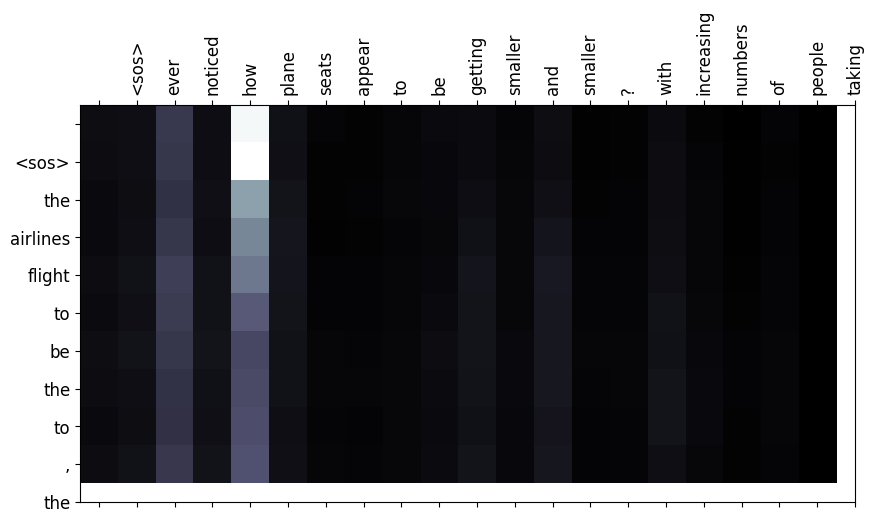

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e6e6dec647a596c961458b98915af9b76c9db1facd8cd7cfa67bdeb026c230c2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score

ROUGE Scores:
rouge1: Score(precision=0.13333333333333333, recall=0.058823529411764705, fmeasure=0.0816326530612245)
rouge2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
rougeL: Score(precision=0.06666666666666667, recall=0.029411764705882353, fmeasure=0.04081632653061225)


Evaluating summaries in batches: 100%|██████████| 180/180 [08:21<00:00,  2.79s/it]


ROUGE-1: 9.1002
ROUGE-2: 1.0809
ROUGE-L: 7.5385


In [34]:
sample_idx = 0
sample_article = test_df.iloc[sample_idx]["article"]
sample_summary = test_df.iloc[sample_idx]["highlights"]

print("Original Article:")
print(sample_article)
print("\nReference Summary:")
print(sample_summary)

# Generate summary
generated_summary, article_tokens, attention = summarize_sentence(
    sample_article,
    model,
    en_tokenizer,
    article_vocab,
    highlights_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=150  # Longer for summaries
)

# Convert tokens to text
generated_summary_text = " ".join(generated_summary[1:-1])  # Remove <sos> and <eos>

print("\nGenerated Summary:")
print(generated_summary_text)

# Visualize attention for the first few words
if len(attention) > 0:
    visualize_attention(
        article_tokens[:20],  # First 20 tokens of article
        generated_summary[:10],  # First 10 tokens of summary
        attention[:10, :, :20]  # Attention for first 10 summary tokens on first 20 article tokens
    )

# Evaluation with ROUGE
!pip install rouge-score
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores = scorer.score(sample_summary, generated_summary_text)

print("\nROUGE Scores:")
for key in scores:
    print(f"{key}: {scores[key]}")

# Batch evaluation on test set
def evaluate_summaries(model, test_data, en_tokenizer, article_vocab, highlights_vocab, device, max_samples=64, group_size=64):
    references = []
    predictions = []
    
    num_samples = min(len(test_data), max_samples)
    num_groups = (num_samples + group_size - 1) // group_size  # Tính số nhóm (batch)

    # Khởi tạo ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    total_rouge1 = 0
    total_rouge2 = 0
    total_rougeL = 0
    total_groups = 0
    
    for group_idx in tqdm.tqdm(range(num_groups), desc="Evaluating summaries in batches"):
        # Tính index bắt đầu và kết thúc của nhóm
        start_idx = group_idx * group_size
        end_idx = min((group_idx + 1) * group_size, num_samples)
        
        batch_references = []
        batch_predictions = []
        
        for i in range(start_idx, end_idx):
            # 1. Lấy article_ids và highlights_ids
            article_ids = test_data[i]['article_ids']
            reference_ids = test_data[i]['highlights_ids']
            
            # 2. Tensor -> List -> Tokens -> Text
            article = " ".join(article_vocab.lookup_tokens(article_ids.tolist()))
            reference = " ".join(highlights_vocab.lookup_tokens(reference_ids.tolist()))
            
            # 3. Generate summary
            summary_tokens, _, _ = summarize_sentence(
                article,
                model,
                en_tokenizer,
                article_vocab,
                highlights_vocab,
                sos_token,
                eos_token,
                device
            )
            generated_summary = " ".join(summary_tokens[1:-1])
            
            batch_references.append(reference)
            batch_predictions.append(generated_summary)

        # Tính ROUGE cho nhóm hiện tại
        for ref, pred in zip(batch_references, batch_predictions):
            scores = scorer.score(ref, pred)
            total_rouge1 += scores['rouge1'].fmeasure
            total_rouge2 += scores['rouge2'].fmeasure
            total_rougeL += scores['rougeL'].fmeasure
        
        total_groups += 1
    
    # Tính trung bình ROUGE của tất cả các nhóm
    avg_rouge1 = total_rouge1 / total_groups
    avg_rouge2 = total_rouge2 / total_groups
    avg_rougeL = total_rougeL / total_groups
    
    print(f"ROUGE-1: {avg_rouge1:.4f}")
    print(f"ROUGE-2: {avg_rouge2:.4f}")
    print(f"ROUGE-L: {avg_rougeL:.4f}")
    
    return predictions, references

# Example: Đánh giá trên toàn bộ dataset, với batch size là 64
predictions, references = evaluate_summaries(
    model,
    test_data,
    en_tokenizer,
    article_vocab,
    highlights_vocab,
    device,
    max_samples=12000,  # Lựa chọn số lượng mẫu muốn test (ví dụ: 2000)
    group_size=64      # Chia dữ liệu thành nhóm 64
)
# Lưu model và vocabularies
torch.save({
    'model_state_dict': model.state_dict(),
    'article_vocab': article_vocab,
    'highlights_vocab': highlights_vocab,
    'sos_token': sos_token,
    'eos_token': eos_token,
}, 'summarization_model.pth')


# Evaluation Results and Observations
The model's generated summary is almost meaningless, consisting mainly of repeated punctuation and disconnected phrases. This results in very low ROUGE scores:

ROUGE-1 F1: 9.10

ROUGE-2 F1: 1.08

ROUGE-L F1: 7.54

Such low scores indicate the model struggles to generate coherent and relevant summaries.

# The main reason is we do not train enough data and do not train enough times (only 10 epoch)

# Suggested Improvements
+ Check training quality: Ensure loss decreases properly and model is not underfitting or overfitting.

+ Use better target preprocessing: Make sure targets (reference summaries) are cleaned and tokenized properly.

+ Improve training signals:

+ Use teacher forcing carefully (maybe increase teacher forcing ratio initially). Try label smoothing or auxiliary losses.

+ Enhance model capacity: Increase hidden dimensions or add more RNN layers. Use pretrained word embeddings (e.g., GloVe) to help embedding quality.

+ Refine Attention: Try different attention mechanisms like Multi-Head Attention or Bahdanau Attention for better context capturing.